# Tutorial for dual_autodiff

This tutorial demonstrates how to use the `dual_autodiff` package for forward-mode automatic differentiation using dual numbers.
We will explore:
- Creating and manipulating dual numbers
- Using mathematical operations
- Applying automatic differentiation


## Installing packages

In [ ]:
pip install rsr45-dual-autodiff

In [ ]:
pip install rsr45-dual-autodiff-x

In [ ]:
pip install numpy

## Import required libraries and modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression
from matplotlib.cm import tab10 

import dual_autodiff
import dual_autodiff_x

from dual_autodiff.dual import Dual as PythonDual
from dual_autodiff.functions import sin as Psin
from dual_autodiff.functions import cos as Pcos
from dual_autodiff.functions import log as Plog

from dual_autodiff_x.dual import Dual as CythonDual
from dual_autodiff_x.functions import sin as Csin
from dual_autodiff_x.functions import cos as Ccos
from dual_autodiff_x.functions import log as Clog

### Creating a dual number

In [3]:
# Create a dual number using the package
x1 = PythonDual(2, 1)  # Real part = 2, Dual part = 1
print("Python Dual number:", x1)

# Create a dual number using cythonised package
x2 = CythonDual(2,1)
print("Cython Dual number:", x2)

Python Dual number: 2 + 1ε
Cython Dual number: 2 + 1ε


### Performing mathematical operations on the dual number

In [4]:
print('Using Python dual_autodiff:')
# Perform mathematical operations
print("sin(x):", Psin(x1))
print("cos(x):", Pcos(x1))
print("log(x):", Plog(x1))

# Combine with another dual number
y1 = PythonDual(3, 0.5)
result1 = x1 + y1
print("Result of x + y * log(x):", result1)

print()

print('Using Cython dual_autodiff_x:')
# Perform mathematical operations
print("sin(x):", Csin(x2))
print("cos(x):", Ccos(x2))
print("log(x):", Clog(x2))

# Combine with another dual number
y2 = CythonDual(3, 0.5)
result2 = x2 + y2

print("Result of x + y:", result2)

Using Python dual_autodiff:
sin(x): 0.9092974268256817 - 0.4161468365471424ε
cos(x): -0.4161468365471424 - 0.9092974268256817ε
log(x): 0.6931471805599453 + 0.5ε
Result of x + y * log(x): 5 + 1.5ε

Using Cython dual_autodiff_x:
sin(x): 0.9092974268256817 - 0.4161468365471424ε
cos(x): -0.4161468365471424 - 0.9092974268256817ε
log(x): 0.6931471805599453 + 0.5ε
Result of x + y: 5 + 1.5ε


### Growth Factor and Comoving Distance Example

In [5]:
# Define functions
def growth_factor(a, omega_m, dual_class):
    a_dual = dual_class(a, 1.0)
    D = a_dual ** 2 
    dD_da = D.dual  # First derivative directly from the dual part
    result = -3 * (omega_m / (a_dual ** 5)) * D + (3 / a_dual) * dD_da
    return result

def comoving_distance(z, H0, omega_m, omega_r, omega_lambda, dual_class):
    z_dual = dual_class(z, 1.0)
    H_z = H0 * ((omega_m * (1 + z_dual) ** 3) +
                (omega_r * (1 + z_dual) ** 4) +
                omega_lambda).real ** 0.5
    return 1 / H_z

# Timing function
def measure_execution_time(func, *args, dual_class, n_iterations=1000):
    start_time = time.time()
    for _ in range(n_iterations):
        func(*args, dual_class=dual_class)
    end_time = time.time()
    return end_time - start_time

# Constants for testing
a = 1.0
z = 0.5
omega_m = 0.3
omega_r = 0.0
omega_lambda = 0.7
H0 = 70.0
n_iterations = 10000

# Measure execution time for growth_factor
python_time_growth = measure_execution_time(growth_factor, a, omega_m, dual_class=PythonDual, n_iterations=n_iterations)
cython_time_growth = measure_execution_time(growth_factor, a, omega_m, dual_class=CythonDual, n_iterations=n_iterations)

# Compute values for growth_factor
growth_value_python = growth_factor(a, omega_m, PythonDual)
growth_value_cython = growth_factor(a, omega_m, CythonDual)

# Measure execution time for comoving_distance
python_time_comoving = measure_execution_time(comoving_distance, z, H0, omega_m, omega_r, omega_lambda, dual_class=PythonDual, n_iterations=n_iterations)
cython_time_comoving = measure_execution_time(comoving_distance, z, H0, omega_m, omega_r, omega_lambda, dual_class=CythonDual, n_iterations=n_iterations)

# Compute values for comoving_distance
comoving_value_python = comoving_distance(z, H0, omega_m, omega_r, omega_lambda, PythonDual)
comoving_value_cython = comoving_distance(z, H0, omega_m, omega_r, omega_lambda, CythonDual)

# Print results
print(f"Growth Factor: Python={python_time_growth:.4f}s, Cython={cython_time_growth:.4f}s")
print(f"Growth Factor Values: Python={growth_value_python.real}, Cython={growth_value_cython.real}")

print(f"Comoving Distance: Python={python_time_comoving:.4f}s, Cython={cython_time_comoving:.4f}s")
print(f"Comoving Distance Values: Python={comoving_value_python.real}, Cython={comoving_value_cython.real}")


Growth Factor: Python=0.0196s, Cython=0.0121s
Growth Factor Values: Python=5.1, Cython=5.1
Comoving Distance: Python=0.0154s, Cython=0.0090s
Comoving Distance Values: Python=0.010916581712869572, Cython=0.010916581712869572


### Angular Diameter Distance Example

In [6]:
def angular_diameter_distance(z, H0, omega_m, omega_r, omega_lambda, dual_class, n_steps=1000):
    c = 3e5  # Speed of light in km/s
    z_values = np.linspace(0, z, n_steps)  # Discretise the redshift range
    dz = z / (n_steps - 1)  # Step size
    
    D_sum_real = 0
    D_sum_dual = 0
    
    for z_i in z_values:
        z_dual = dual_class(z_i, 1.0)  # Create dual number for each z_i
        H_z = H0 * ((omega_m * (1 + z_dual) ** 3) +
                    (omega_r * (1 + z_dual) ** 4) +
                    omega_lambda).sqrt()
        D_sum_real += (c / H_z.real) * dz  # Trapezium sum for real part
        D_sum_dual += (c / H_z.dual) * dz  # Trapezium sum for derivative part

    # Angular diameter distance
    D_A_real = D_sum_real / (1 + z)
    D_A_dual = D_sum_dual / (1 + z)
    
    return D_A_real, D_A_dual

# Constants
z = 2.0
H0 = 70.0
omega_m = 0.3
omega_r = 0.0
omega_lambda = 0.7

# Compute angular diameter distance using Python and Cython dual classes
D_A_python, D_A_derivative_python = angular_diameter_distance(z, H0, omega_m, omega_r, omega_lambda, PythonDual)
D_A_cython, D_A_derivative_cython = angular_diameter_distance(z, H0, omega_m, omega_r, omega_lambda, CythonDual)

# Print results
print(f"Angular Diameter Distance (Python): {D_A_python:.2f} Mpc, Derivative: {D_A_derivative_python:.2f}")
print(f"Angular Diameter Distance (Cython): {D_A_cython:.2f} Mpc, Derivative: {D_A_derivative_cython:.2f}")


Angular Diameter Distance (Python): 1729.73 Mpc, Derivative: 3177.59
Angular Diameter Distance (Cython): 1729.73 Mpc, Derivative: 3177.59


# Differentiating the function defined in task 5 using dual numbers

In this section we compare the analytical derivative and the derivative using dual numbers.

We go on to explore how the numerical derivative diverges from the true derivative with increasing step size.

$$f(x) = \text{log}(\text{sin}(x)) + x^2 \cdot \text{cos}(x)$$

$$f'_{\text{analytical}}(x) = \frac{\cos(x)}{\sin(x)} -x^2 \cdot \sin(x) + 2x \cdot \cos(x)$$

$$f'_{\text{numeric}}(x) \approx \frac{f(x + h) - f(x - h)}{2h}$$




In [4]:
def f_dual(x):
    return Plog(Psin(x)) + x**2 * Pcos(x)

# Compute f(x) and its derivative at x = 1.5 using Dual numbers
x_val_dual = PythonDual(1.5, 1)
result_dual = f_dual(x_val_dual)

print("Using Dual Numbers:")
print(f"f(1.5) using Dual Numbers: {result_dual.real:.17g}")
print(f"f'(1.5) using Dual Numbers: {result_dual.dual:.17g}")

# Function definition using double-precision floats
def f(x):
    return np.log(np.sin(x)) + x**2 * np.cos(x)

# Compute f'(x) analytically
def df(x):
    m1 = -(x**2) * np.sin(x)
    m2 = np.cos(x) / np.sin(x)
    m3 = 2 * x * np.cos(x)
    return m1 + m2 + m3

# Calculate f(x) and its derivative at x = 1.5 using manual computation
x_val = 1.5
f_result = f(x_val)
df_result = df(x_val)

print("\nUsing Analytical Computation:")
print(f"f(1.5) using Analytical Computation: {f_result:.17g}")
print(f"f'(1.5) using Analytical Computation: {df_result:.17g}")

Using Dual Numbers:
f(1.5) using Dual Numbers: 0.15665054756073515
f'(1.5) using Dual Numbers: -1.9612372705533612

Using Analytical Computation:
f(1.5) using Analytical Computation: 0.15665054756073515
f'(1.5) using Analytical Computation: -1.9612372705533614


Plot saved successfully to: /Users/raunaqrai/Documents/DIS/coursework/c1/dual_autodiff/report/convergence_derivative.png


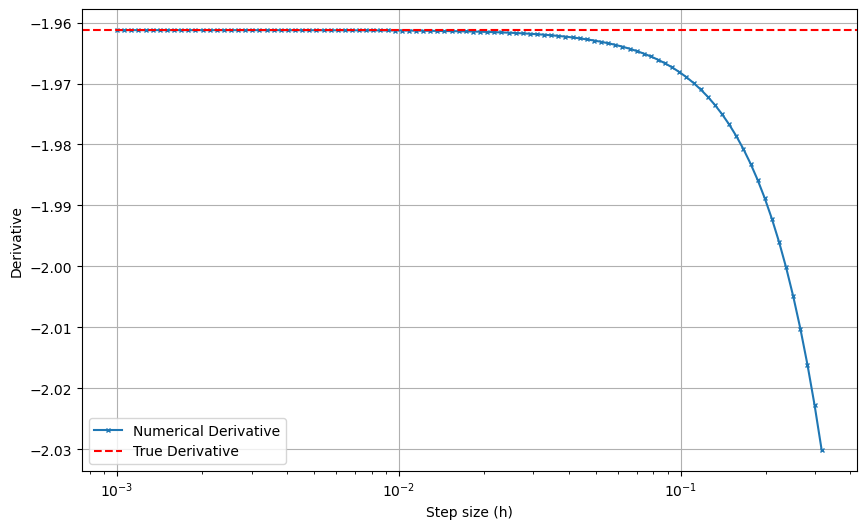

In [ ]:
# Numerical derivative using finite differences
def numerical_derivative(f, x, h):
    return (f(x + h) - f(x - h)) / (2 * h)

# Function for numerical computation
def f_numeric(x):
    return np.log(np.sin(x)) + x**2 * np.cos(x)

# Compute derivatives for decreasing step sizes
x_val = 1.5
steps = np.logspace(-0.5, -3, 100)
numerical_results = [numerical_derivative(f_numeric, x_val, h) for h in steps]

# True value for comparison
true_derivative = f(PythonDual(x_val, 1)).dual

# Compute differences
differences = np.abs(np.array(numerical_results) - true_derivative)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(steps, numerical_results, label="Numerical Derivative", marker='x', markersize=3)
plt.axhline(y=true_derivative, color='r', linestyle='--', label="True Derivative")

plt.xscale("log")
plt.xlabel("Step size (h)")
plt.ylabel("Derivative")
plt.legend()
plt.grid()

# Save the figure in high resolution
save_path = "/Users/raunaqrai/Documents/DIS/coursework/c1/dual_autodiff/report/convergence_derivative.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 
print(f"Plot saved successfully to: {save_path}")

plt.show()


# Task 9 - The performance of the pure Python version (dual_autodiff) and the Cythonized version (dual_autodiff_x)

In [23]:
#defining mulitple functions with a range of complexities

def linear_function(x):
    return x + 2

def quadratic_function(x):
    return x ** 2 + 3 * x + 5

def trig_function(x):
    return x.sin() + (x ** 2).cos()

def log_function(x):
    return x.log() + x ** 2

def composite_function(x):
    return (x.sin() + 1).log() + x ** 2 * x.cos()

def nested_function(x):
    return (x ** 2).exp() - (x.sin() + x ** 3).sqrt()

def iterative_function(x, n=100):
    result = x
    for i in range(1, n + 1):
        result += (x + i) ** 2
    return result

def piecewise_function(x):
    if x.real < 1:
        return x ** 2
    else:
        return x.sin() + x.log()

def iterative_exponential_function(x, n=100):
    result = x
    for i in range(1, n + 1):
        result += (x + i).exp() - (x ** 2 + i).sqrt()
    return result

def high_degree_polynomial(x):
    return x ** 7 + 6 * x ** 6 + 15 * x ** 5 + 20 * x ** 4 + 15 * x ** 3 + 6 * x ** 2 + x

def nested_square_root_log(x):
    return x.sqrt().sqrt().sqrt().log()

def recursive_function(x, n=5):
    if n == 1:
        return x.sqrt() + x * x.cos()
    else:
        return recursive_function(x, n - 1).sqrt() + x * x.sin()

def composite_conditional_function(x):
    if x.real < 2:
        return (x ** 2).sin() + x.log()
    else:
        return x.exp() - x ** 3

def long_iterative_function(x, n=100):
    result = x
    for i in range(1, n + 1):
        result += (x + i).sin() + (x * i).cos().exp() - (x + i ** 2).log()
    return result

test_functions = [
    linear_function,
    quadratic_function,
    trig_function,
    log_function,
    composite_function,
    nested_function,
    iterative_function,
    piecewise_function,
    iterative_exponential_function,
    high_degree_polynomial,
    nested_square_root_log,
    recursive_function,
    composite_conditional_function,
    long_iterative_function
]


In [24]:
# function to measure execution times
def measure_execution_time(dual_class, func, n_iterations=10000):
    start_time = time.time()
    x = dual_class(2, 1)
    for _ in range(n_iterations):
        func(x)
    end_time = time.time()
    return end_time - start_time


In [ ]:
#print the differences between Python and Cython implementation
for func in test_functions:
    python_time = measure_execution_time(PythonDual, func, n_iterations=10000)
    cython_time = measure_execution_time(CythonDual, func, n_iterations=10000)
    print(f"{func.__name__}: Python={python_time:.4f}s, Cython={cython_time:.4f}s")

linear_function: Python=0.0033s, Cython=0.0022s
quadratic_function: Python=0.0162s, Cython=0.0090s
trig_function: Python=0.0277s, Cython=0.0203s
log_function: Python=0.0109s, Cython=0.0082s
composite_function: Python=0.0293s, Cython=0.0242s
nested_function: Python=0.0283s, Cython=0.0235s
iterative_function: Python=0.6959s, Cython=0.4566s
piecewise_function: Python=0.0146s, Cython=0.0127s
iterative_exponential_function: Python=2.0479s, Cython=1.5336s
high_degree_polynomial: Python=0.0438s, Cython=0.0312s
nested_square_root_log: Python=0.0189s, Cython=0.0151s
recursive_function: Python=0.0833s, Cython=0.0731s
composite_conditional_function: Python=0.0114s, Cython=0.0099s
long_iterative_function: Python=3.5448s, Cython=2.9419s


There is a clear performance difference between the pure Python and the Cythonized implementations, particularly for more computationally intensive functions.


For simpler functions like linear_function, quadratic_function, and piecewise_function, the performance difference between Python and Cythonized versions is minimal. These functions involve minimal computations, so the overhead of function calls dominates execution time. Cython's optimisations are less significant here.

For highly iterative or nested functions like iterative_function, iterative_exponential_function, and long_iterative_function, the Cythonized version outperforms the Python version. These functions involve extensive loops and nested operations, where Cython's optimisations, such as converting loops into C-style iterations, reduce overhead.

Cythonization is most effective when applied to functions with high computational loads or extensive loops, while the benefits for simpler functions are minimal.

In [90]:
# Define a simple test function
def test_function(dual_array):
    result = dual_array[0]
    for dual in dual_array[1:]:
        result += dual.sin() * dual ** 2
    return result

In [91]:
def measure_execution_time_varying_dual(dual_class, array_length, dual_range, n_iterations=100):
    """
    Measures the execution time for a given dual class with varying array lengths and dual number values.
    
    Parameters:
    - dual_class: The Dual class implementation (Python or Cythonized).
    - array_length: Length of the array of dual numbers.
    - dual_range: Tuple (start, stop) to generate the range of real parts of dual numbers.
    - n_iterations: Number of iterations for repeated function evaluation.
    
    Returns:
    - Execution time in seconds.
    """
    real_values = np.linspace(dual_range[0], dual_range[1], array_length)
    dual_array = [dual_class(real, 1.0) for real in real_values]  # Dual numbers with varying real parts
    start_time = time.time()
    for _ in range(n_iterations):
        test_function(dual_array)
    end_time = time.time()
    return end_time - start_time


Plot saved successfully to: /Users/raunaqrai/Documents/DIS/coursework/c1/dual_autodiff/report/performance_comparison.png


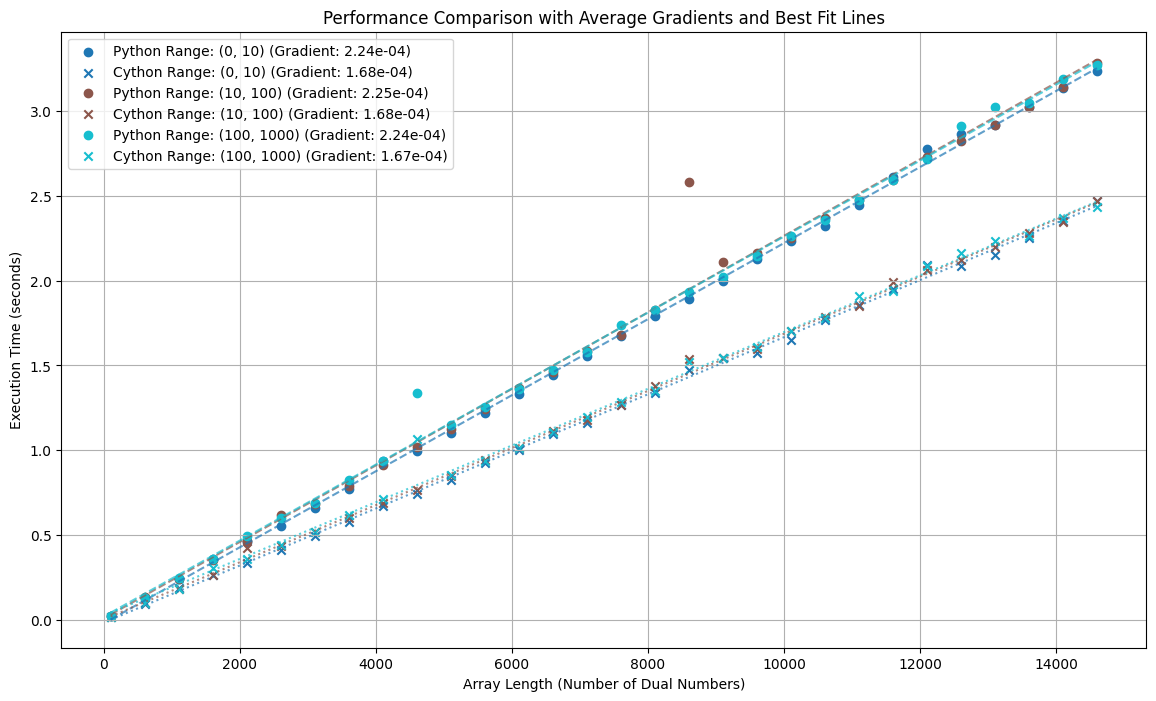

In [ ]:
# Function to measure execution time
def measure_execution_time_varying_dual(dual_class, array_length, dual_range, n_iterations=100):
    # Generate dual numbers with varying ranges
    dual_array = [dual_class(np.random.uniform(*dual_range), 1.0) for _ in range(array_length)]
    start_time = time.time()
    for _ in range(n_iterations):
        test_function(dual_array)
    end_time = time.time()
    return end_time - start_time

# Array lengths and ranges for dual numbers
array_lengths = np.arange(100, 15000, 500)  
dual_ranges = [(0, 10), (10, 100), (100, 1000)]  # Varying ranges for the real parts of dual numbers

# Assign colors to each range
colors = tab10(np.linspace(0, 1, len(dual_ranges)))

# Performance measurements
results = {}

for dual_range in dual_ranges:
    python_times = []
    cython_times = []
    for length in array_lengths:
        python_time = measure_execution_time_varying_dual(PythonDual, length, dual_range)
        cython_time = measure_execution_time_varying_dual(CythonDual, length, dual_range)
        python_times.append(python_time)
        cython_times.append(cython_time)
    results[dual_range] = (python_times, cython_times)

# Gradient calculation and regression
gradients = {}
line_fits = {}

for dual_range, (python_times, cython_times) in results.items():
    # Perform linear regression for Python and Cython
    python_model = LinearRegression().fit(array_lengths.reshape(-1, 1), python_times)
    cython_model = LinearRegression().fit(array_lengths.reshape(-1, 1), cython_times)

    # Store the slope (average gradient) and predictions
    gradients[dual_range] = (python_model.coef_[0], cython_model.coef_[0])
    line_fits[dual_range] = (
        python_model.predict(array_lengths.reshape(-1, 1)),
        cython_model.predict(array_lengths.reshape(-1, 1))
    )

# Plotting results
plt.figure(figsize=(14, 8))

for i, (dual_range, (python_times, cython_times)) in enumerate(results.items()):
    python_grad, cython_grad = gradients[dual_range]
    label_range = f"Range: {dual_range}"
    python_label = f"Python {label_range} (Gradient: {python_grad:.2e})"
    cython_label = f"Cython {label_range} (Gradient: {cython_grad:.2e})"
    color = colors[i]

    # Scatter plot for data points
    plt.scatter(array_lengths, python_times, label=python_label, marker="o", color=color)
    plt.scatter(array_lengths, cython_times, label=cython_label, marker="x", color=color)

    # Line of best fit
    python_fit, cython_fit = line_fits[dual_range]
    plt.plot(array_lengths, python_fit, linestyle="--", color=color, alpha=0.7)
    plt.plot(array_lengths, cython_fit, linestyle=":", color=color, alpha=0.7)

plt.xlabel("Array Length (Number of Dual Numbers)")
plt.ylabel("Execution Time (seconds)")
plt.title("Performance Comparison with Average Gradients and Best Fit Lines")
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
# Save the figure in high resolution
save_path = "/Users/raunaqrai/Documents/DIS/coursework/c1/dual_autodiff/report/performance_comparison.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Plot saved successfully to: {save_path}")
plt.show()

